## Setup

In [1]:
# Imports
from os import getenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from helpers.wrangle import clean_game_data

### Database Connection

In [2]:
# Database connection
load_dotenv()
url = getenv('DB_URI')
db_conn = create_engine(url)

### Load Data

In [3]:
# Load tables to dataframes
df = pd.read_sql_table('game', db_conn, index_col='id')
df = clean_game_data(df)

## Developing the metric

### Why?

The idea behind developing a 'popularity' metric is to find a way to quantify
the BoardGameGeek.com (BGG) community sentiment towards individual games. Then in turn,
we can use it to compare groups of games to find trends and preferences.

### What do we have to work with?

From the BGG dataset, we already have a lot of different pieces of data that
reveal parts of the community sentiment towards games:

- The average and bayes/BGG/Geek ratings give good estimations of how the community
feels about the quality of a game, the latter especially so with its inherent
normalization.

- The standard deviation of each game's rating distribution gives us context of
how divisive or unifying a game is to the subset of the community who submitted
a ranking

- The total ratings and owned copies counts quantify how many people have played
and/or acquired (through purchase or trade) each game.

These three data give us an excellent spot to start developing a more all
encompassing metric of community sentiment, which I will refer to as 'popularity'.

### What is our goal?

In developing a popularity metric, the aim is to have a quantitative description
of the popularity of a game. We can further break this up into two parts: 
direction and magnitude.

Direction is a simple indication of whether the community has a negative or
positive sentiment towards the game. Is the game liked? Or is it disliked?

Magnitude will give a measure of how strong or widespread that sentiment is
across the community. Is a game liked, or is it loved?

In sum, I aim to derive a metric that quantifies the popularity of a game and
indicates both the direction and magnitude of community sentiment.

### Calculating popularity

Given the stated goal of what the final result should satisfy, we have two
data that are quantifying things we are looking for. The total ratings count
is an excellent place to start for our magnitude. The more people who rate a
game, the more strongly or widespread we can conclude the result is.

The bayes rating also gives us some information on magnitude. A game rated as
10/10 is definitely more favorably viewed than one that is 8/10. Combining these
two data will give an excellent quantification of magnitude: how highly or lowly
is a game rated, multiplied by the total number of people who contributed to the
overall rating!

We now have the foundations of a formula to quantify popularity:

> $\text{popularity} = \text{bayes\_rating} * \text{total\_ratings}$

Next, we need to find a way to indicate direction. Using the sign of the number
representing popularity will be the simplest and clearest way to express
direction.

Conveniently, the bayes rating can also give us our direction!

The purpose behind the bayes rating, is to regulate how high or low the rating
of a game can get without massive numbers of people contributing to the overall
rating. The bayes rating adds about 100 'dummy votes' of 5.5, to keep games with
fewer ratings from climbing to the top of the site's rankings with only a few
people giving abnormally high marks. This is referred to as Bayesian Averaging.

However, this also affects games rated very poorly. If not enough people are
rating a game at a very low level, the bayes rating will be pulled up towards
5.5 by the 'dummy votes'. By shifting this rating down by 5.5, we now have a
proxy for the direction of popularity:

> $\text{popularity} = (\text{bayes\_rating} - 5.5) * \text{total\_ratings}$

Let's take a look at what our new metric says are the community's 10 most liked,
and 10 most disliked, games:

In [4]:
df['popularity'] = ((df.bayes_rating - 5.5) * df.total_ratings)

print("Ten most liked games (descending):")
display(df[['title', 'release_year', 'avg_rating', 'bayes_rating', 'total_ratings', 'popularity']].sort_values('popularity', ascending=False).head(10))

print("Ten most disliked games (descending):")
display(df[['title', 'release_year', 'avg_rating', 'bayes_rating', 'total_ratings', 'popularity']].sort_values('popularity', ascending=True).head(10))

Ten most liked games (descending):


,title,release_year,avg_rating,bayes_rating,total_ratings,popularity
id,,,,,,
167791,Terraforming Mars,2016,8.39822,8.25296,82061,225910.65056
30549,Pandemic,2008,7.56898,7.46647,114273,224714.42631
822,Carcassonne,2000,7.41435,7.30434,114171,206003.30214
68448,7 Wonders,2010,7.71593,7.61258,94699,200059.21342
173346,7 Wonders Duel,2015,8.10200,7.97893,77267,191539.48431
169786,Scythe,2016,8.19605,8.04247,70668,179671.26996
36218,Dominion,2008,7.60489,7.49081,84512,168247.33472
13,CATAN,1995,7.11921,6.95024,113905,165189.58720
266192,Wingspan,2019,8.08224,7.93232,67386,163904.31552


Ten most disliked games (descending):


,title,release_year,avg_rating,bayes_rating,total_ratings,popularity
id,,,,,,
1406,Monopoly,1935,4.36223,4.29269,32263,-38951.44253
2921,The Game of Life,1960,4.31377,4.32089,11887,-14016.08057
5432,Chutes and Ladders,-200,2.87528,3.61869,4265,-8023.78715
5048,Candy Land,1949,3.20122,3.81498,4455,-7506.76410
2425,Battleship,1931,4.67888,4.73252,9640,-7398.50720
11901,Tic-Tac-Toe,-1300,2.71419,3.60060,3606,-6849.23640
2407,Sorry!,1929,4.52257,4.65775,6418,-5405.56050
2223,UNO,1971,5.42439,5.31727,24904,-4550.70792
1410,Trouble,1965,3.82373,4.30916,3708,-4415.63472


As an avid boardgame hobbyist myself, both of these lists make a lot of sense
and match my anecdotal experiences discussing board games with other hobbyists.
This at least indicates that we are on the right track in attempting to quantify
the popularity of games among the board-gaming community that makes up our dataset.

It is also exciting to see that our new metric also gives a different ordering
of games than either of the rating metrics do!

Now that we have our formula, lets take a look at the distribution of our new
metric.

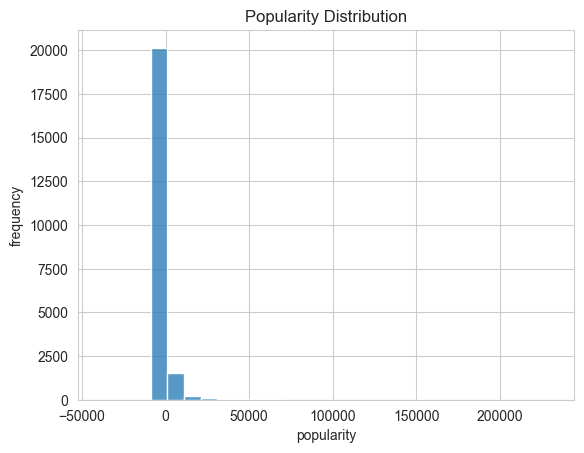

In [5]:
plt.title('Popularity Distribution')
plt.ylabel('frequency')
sns.histplot(df.popularity, binwidth=10000);

That is not exactly what I would call an informative, or interesting, graphic.

Let's take a look at a box plot for a better look at what is going on:

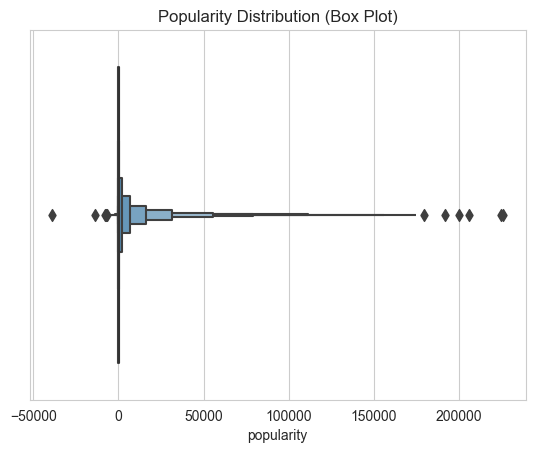

In [6]:
plt.title('Popularity Distribution (Box Plot)')
sns.boxenplot(x=df.popularity);

The box plot shows us that the extremes of our distribution are very
extreme! You might have noticed this if you compared the popularity values in
the top/bottom 10 lists above to the histogram plot.

With the formula working in giving us direction and relative magnitude of
popularity, in order to properly visualize it, its output needs to be adjusted to
values more comparable to each other.

### Adjusting the Population Metric

There are a couple ways that we could go about adjusting our 'raw' popularity
numbers: square roots or logarithms.

With the extreme nature of the distribution, I will be using the natural logarithm
for its more pronounced depression of larger numbers.

Because logarithms are only defined for numbers greater than 0, and return a
negative number for numbers between 0 and 1, additional adjustments must be made
when applying the log:

1. We will take the log of $|p| + 1$, this will adjust the magnitude and keep
our lower bound at zero.
2. We will carry over the sign of the unadjusted figure to our adjusted figure.

In [7]:
# Adjust the popularity metric to a smaller scale using the natural log
def adjust_pop(n):
    
    # Add 1 to the absolute value to keep all resulting numbers positive, with
    # a lower bound of 0
    ap = np.log(np.abs(n) + 1)
    
    # Keep the sign of the unadjusted number
    if n < 0:
        ap *= -1
    return ap

# Save the adjusted metric as a separate column
df['popularity_adj'] = df.popularity.apply(adjust_pop)

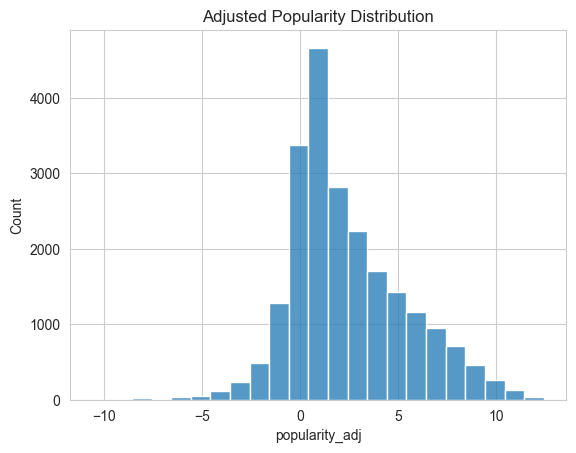

In [8]:
plt.title('Adjusted Popularity Distribution')
sns.histplot(df.popularity_adj, binwidth=1);

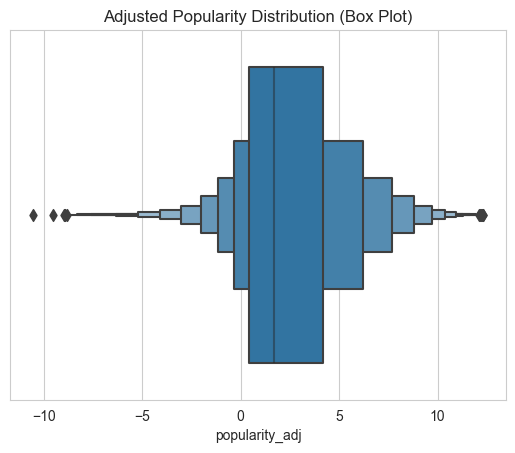

In [9]:
plt.title('Adjusted Popularity Distribution (Box Plot)')
sns.boxenplot(x=df.popularity_adj);

Our distribution now looks much better! We can now visually explore how our new
measure of popularity correlates with the rest of the dataset.

## Examining the dataset with our new feature

Using the Seaborn pairplot() function, we can get a quick look at relationships
between population_adj and each other feature of our dataset.

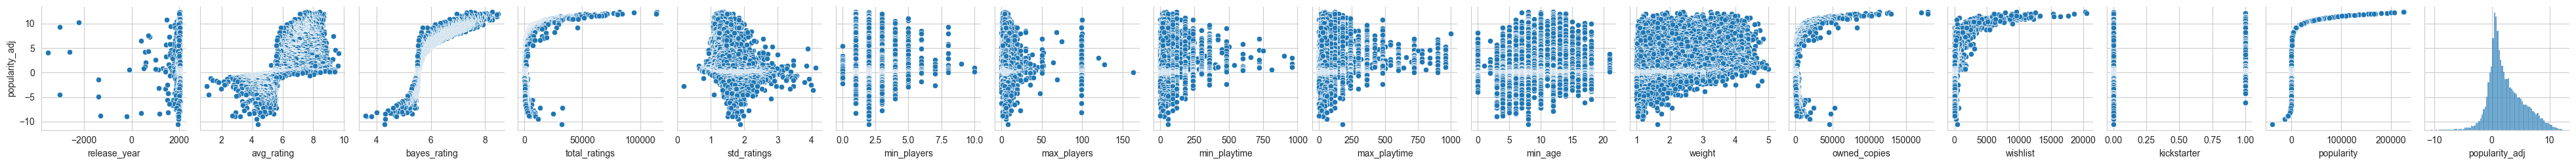

In [14]:
sns.pairplot(data=df, y_vars=['popularity_adj']);

Of these, the total_ratings and weight plots look especially interesting.

#### Total Ratings

First we will take a look at the relationship with total_ratings. I will add
avg_rating as the hue of the plot so that we can see that relationship as well.

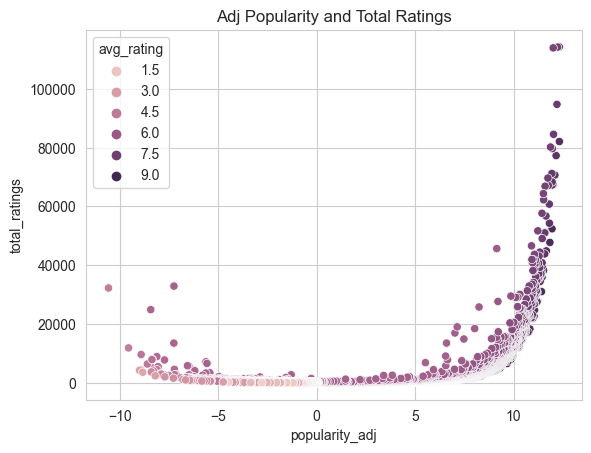

In [11]:
plt.title('Adj Popularity and Total Ratings')
sns.scatterplot(data=df, x='popularity_adj', y='total_ratings', hue='avg_rating');

Since all data around 0 is being compressed to a near straight line, lets
redraw the plot with the total_ratings axis adjusted to a logarithmic scale.

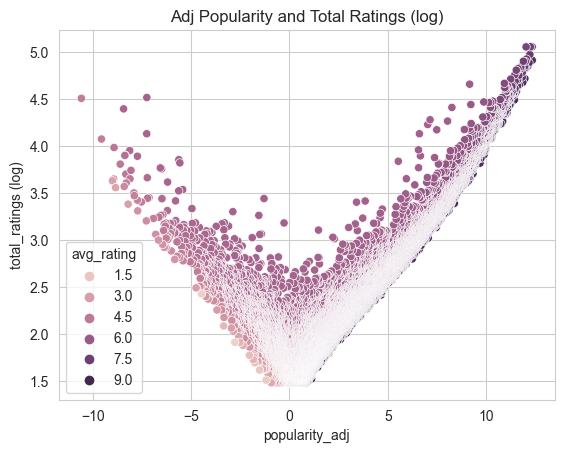

In [12]:
plt.ylabel('total_ratings (log)')
plt.title('Adj Popularity and Total Ratings (log)')
sns.scatterplot(x=df.popularity_adj, y=np.log10(df.total_ratings), hue=df.avg_rating);

We can see that the data forms the shape of a fishtail, with total ratings
rising exponentially as the magnitude of popularity increases in either
direction. This makes sense as total ratings is *the* driving factor in the
calculation of magnitude!

While a bit counter-intuitive, the negative side of the fishtail makes sense in
the context of total ratings being the driver of magnitude, separate from
direction. With the average rating overlay, you may notice that there is a strong
tendency for the games on the 'top' of the fishtail to have higher average
ratings than those directly below them.

There is also a trend of games with larger total ratings counts having more
moderate average ratings.

#### Weight

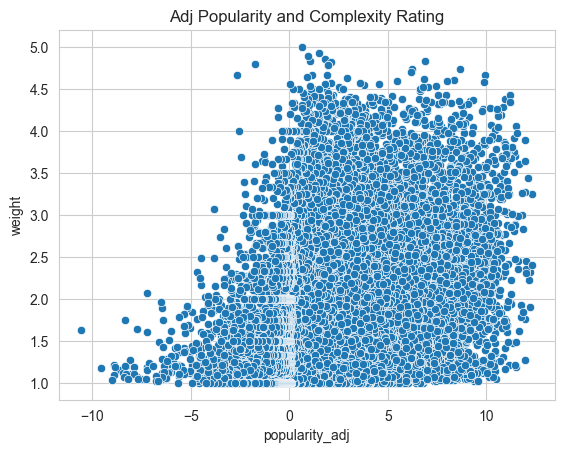

In [13]:
plt.title('Adj Popularity and Complexity Rating')
sns.scatterplot(data=df, x='popularity_adj', y='weight');

Charting popularity against weight (complexity) reveals an interesting trend
of negatively viewed games to have very low weights. Neutral and positively
viewed games are spread across the weight spectrum.

A possible explanation for this is that board gamers tend to look down upon games
they view as 'simple', and are more likely to negatively rate them than they would
a more complex game that is of similar 'quality'.

Another reason could be that non board gamers play almost exclusively 'low complexity'
games. More avid board gamers may be exposed to many of these low complexity
games in the context of family and friends and end up playing games they do not
enjoy for the sake of social convenience. They would then go and review said games
poorly on BGG. Rinse and repeat for thousands of hobbyists, and you have the
makings of our Most Disliked Boardgames list!

## Conclusions

The total ratings and adjusted popularity chart gives a good
illustration of what the popularity metric is, and more importantly *is not*
measuring:

- Popularity **is** measuring how much engagement the community has with a game.
- It **is not** measuring how good a game is. The size of the total_ratings
factor greatly dwarfs the bayes_rating factor, so a more widely played game that
is generally considered very good will have an equal or higher popularity score
than a niche game that is considered perfect by the small group that has played
and rated it.
- It **is** indicating whether general sentiment towards a game is negative or
positive.

Another point to note is that the 'popularity' being measured is that of the
BGG user community, which is composed of dedicated boardgame hobbyists, and is
not reflective of the opinions of the larger public. As with all findings from
this dataset, they are likely more indicative of the nature and opinions of the
BGG and board gaming community than the games themselves.

Overall, this implementation of a popularity metric gives a new way to examine how
games in this dataset are viewed and received by the community.